## Overview of mapping tools in Data Science

### Static maps

#### R's fields package

```R
library(fields)
data(NorthAmericanRainfall)
x<- cbind(NorthAmericanRainfall$longitude, NorthAmericanRainfall$latitude)
y<- NorthAmericanRainfall$precip
quilt.plot(x,y)
world(add=TRUE)
```

![](./odsc-assets/fields.png)

#### Altair

Python interface for [vega](https://vega.github.io/vega/).

```python
import altair as alt
from vega_datasets import data

counties = alt.topo_feature(data.us_10m.url, 'counties')
source = data.unemployment.url

alt.Chart(counties).mark_geoshape().encode(
    color='rate:Q'
).transform_lookup(
    lookup='id',
    from_=alt.LookupData(source, 'id', ['rate'])
).project(
    type='albersUsa'
).properties(
    width=500,
    height=300
)
```

![](./odsc-assets/altair.png)

[source](https://altair-viz.github.io/index.html)

#### Bokeh

```python
from bokeh.plotting import figure, show, output_notebook
from bokeh.tile_providers import CARTODBPOSITRON
# range bounds supplied in web mercator coordinates
p = figure(x_axis_type="mercator", y_axis_type="mercator")
p.add_tile(CARTODBPOSITRON)
p.circle(x=Merged['coords_x'],
         y=Merged['coords_y'], 
         size=Merged['circle_sizes'],
         line_color="#FF0000", 
         fill_color="#FF0000",
         fill_alpha=0.05)
    
output_notebook()
show(p)
```

<img src="./odsc-assets/bokeh.png" alt="bokeh" style="width: 500px;" />

[source](https://towardsdatascience.com/exploring-and-visualizing-chicago-transit-data-using-pandas-and-bokeh-part-ii-intro-to-bokeh-5dca6c5ced10)

## Interactive Maps

### Plotly

```python
import plotly.plotly as py
import plotly.graph_objs as go

import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2014_us_cities.csv')
df.head()

df['text'] = df['name'] + '<br>Population ' + (df['pop']/1e6).astype(str)+' million'
limits = [(0,2),(3,10),(11,20),(21,50),(50,3000)]
colors = ["rgb(0,116,217)","rgb(255,65,54)","rgb(133,20,75)","rgb(255,133,27)","lightgrey"]
cities = []
scale = 5000

for i in range(len(limits)):
    lim = limits[i]
    df_sub = df[lim[0]:lim[1]]
    city = go.Scattergeo(
        locationmode = 'USA-states',
        lon = df_sub['lon'],
        lat = df_sub['lat'],
        text = df_sub['text'],
        marker = go.scattergeo.Marker(
            size = df_sub['pop']/scale,
            color = colors[i],
            line = go.scattergeo.marker.Line(
                width=0.5, color='rgb(40,40,40)'
            ),
            sizemode = 'area'
        ),
        name = '{0} - {1}'.format(lim[0],lim[1]) )
    cities.append(city)

layout = go.Layout(
        title = go.layout.Title(
            text = '2014 US city populations<br>(Click legend to toggle traces)'
        ),
        showlegend = True,
        geo = go.layout.Geo(
            scope = 'usa',
            projection = go.layout.geo.Projection(
                type='albers usa'
            ),
            showland = True,
            landcolor = 'rgb(217, 217, 217)',
            subunitwidth=1,
            countrywidth=1,
            subunitcolor="rgb(255, 255, 255)",
            countrycolor="rgb(255, 255, 255)"
        )
    )

fig = go.Figure(data=cities, layout=layout)
py.iplot(fig, filename='d3-bubble-map-populations')
```

<img src="./odsc-assets/plotly.gif" alt="plotly" style="width: 500px" />

### Leaflet.js: [Folium](https://python-visualization.github.io/folium) (Python) and [Leaflet for R](https://rstudio.github.io/leaflet/) (R)

```python
import branca

county_data = os.path.join('data', 'us_county_data.csv')
county_geo = os.path.join('data', 'us_counties_20m_topo.json')

df = pd.read_csv(county_data, na_values=[' '])


colorscale = branca.colormap.linear.YlOrRd_09.scale(0, 50e3)
employed_series = df.set_index('FIPS_Code')['Employed_2011']


def style_function(feature):
    employed = employed_series.get(int(feature['id'][-5:]), None)
    return {
        'fillOpacity': 0.5,
        'weight': 0,
        'fillColor': '#black' if employed is None else colorscale(employed)
    }


m = folium.Map(
    location=[48, -102],
    tiles='cartodbpositron',
    zoom_start=3
)

folium.TopoJson(
    open(county_geo),
    'objects.us_counties_20m',
    style_function=style_function
).add_to(m)
```

<img src="./odsc-assets/folium.gif" alt="folium" style="width: 500px" />

### cartoframes

```python
vl.Map(layers=[
        vl.Layer('seattle_collisions',
                {'width': 'ramp(linear($personcount, 2, 5), [5, 20]) * animation(linear($incdate), 20,fade(1, 1))',
                 'color': 'opacity(turquoise, 0.8)',
                 'stroke-width': 0})
    ],
    context=CartoContext(base_url='https://cartovl.carto.com/', api_key='default_public'),
    basemap=basemaps.Basemaps.darkmatter
)
```

<img src="./odsc-assets/cartoframes.gif" alt="plotly" style="width: 500px" />

## Demo / mini-workshop

To follow along, visit:
### https://github.com/andy-esch/odsc-cartography

Follow README

1. Clone me: `$ git clone https://github.com/andy-esch/odsc-cartography.git`
2. Pip install things
  - I prefer pipenv: `$ pipenv install -r requirements.txt`
  - Or use pip: `pip install -r requirements.txt`
3. Run your jupyter server
  - Pipenv: `pip run jupyter notebook`

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartoframes.carto_vl as vl
from cartoframes.carto_vl.basemap import basemaps
from cartoframes import CartoContext, Credentials
import pandas as pd
from IPython.display import Image

cc = CartoContext(
    base_url='https://eschbacher.carto.com/',
    api_key='default_public'
)

## Defaults

We'll work with [Seattle vehicle collisions](https://data.seattle.gov/Transportation/Collisions/vac5-r8kk).

In [2]:
vl.Map(layers=[
        vl.Layer('seattle_collisions'),
    ],
    context=cc
)

## Color by magnitude

Let's communicate data on our map -- styling our points by an attribute value. E.g., let's look at `personcount`, the number of people involved in a collision.

/Users/aeschbacher/.local/share/virtualenvs/odsc-cartography-gK7cOzdj/lib/python3.7/site-packages/cartoframes/datasets.py:36: UserWarning: Table will be named `seattle_collisions`
  warn('Table will be named `{}`'.format(table_name))


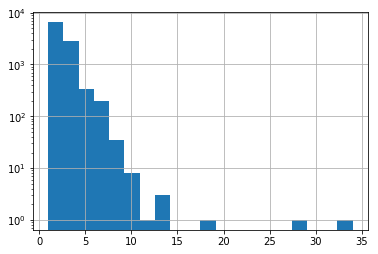

In [3]:
df = cc.read('seattle_collisions')
df.personcount.hist(bins=20)
plt.yscale('log', nonposy='clip')

In [4]:
vl.Map(layers=[
        vl.Layer('seattle_collisions',
                {'color': 'ramp($personcount, bluyl)',
                 'stroke-width': 0.5})
    ],
    context=cc
)

## Add more contrast with a darker basemap

In [5]:
vl.Map(layers=[
        vl.Layer('seattle_collisions',
              {'color': 'ramp($personcount, bluyl)',
               'stroke-width': 0.5})
    ],
    context=cc,
    basemap=basemaps.Basemaps.darkmatter
)

Our ramp is light to dark (low `personcount` values to high `personcount` values), so we should reverse our ramp to let the higher count values appear more prominently than the low count values.

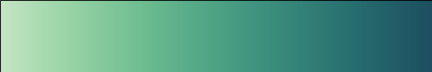

In [6]:
from palettable.cartocolors.sequential import BluGrn_7
BluGrn_7.show_continuous_image()

## Reverse the ramp

In [7]:
vl.Map(layers=[
        vl.Layer('seattle_collisions',
              {'color': 'ramp($personcount, reverse(bluyl))',
               'stroke-width': 0.5})
    ],
    context=cc,
    basemap=basemaps.Basemaps.darkmatter
)

But now there are a few problems that prevent us from seeing patterns:

- marker outlines are too bright and distract from the markers

## Darken the outline

Let's darken the outline so the values in the markers pops out more.

In [8]:
vl.Map(layers=[
        vl.Layer('seattle_collisions',
              {'color': 'ramp($personcount, reverse(bluyl))',
               'stroke-width': 0.5,
               'stroke-color': 'rgba(51, 51, 51, 0.3)'})
    ],
    context=cc,
    basemap=basemaps.Basemaps.darkmatter
)

## Smaller ones are brighter against the basemap

We can handle this by reversing the color ramp

In [9]:
vl.Map(layers=[
        vl.Layer('seattle_collisions',
              {'color': 'ramp($personcount, reverse(bluyl))',
               'stroke-width': 0.5,
               'stroke-color': 'rgba(51, 51, 51, 0.3)'})
    ],
    context=cc,
    basemap=basemaps.Basemaps.darkmatter
)

## Add redundant cartography

- To further highlight the points we want to highlight, let's size them by the same feature

In [10]:
vl.Map(layers=[
        vl.Layer('seattle_collisions',
              {'color': 'ramp($personcount, reverse(bluyl))',
               'stroke-width': 0.5,
               'stroke-color': 'rgba(51, 51, 51, 0.3)',
               'width': 'ramp(globalEqIntervals($personcount, 10), [3, 12])'})
    ],
    context=cc,
    basemap=basemaps.Basemaps.darkmatter
)

## Add ordering to make larger values appear on the top

In [11]:
vl.Map(layers=[
        vl.Layer('seattle_collisions',
              {'color': 'ramp($personcount, reverse(bluyl))',
               'stroke-width': 0.5,
               'stroke-color': 'rgba(51, 51, 51, 0.3)',
               'width': 'ramp(globalEqIntervals($personcount, 10), [3, 12])',
               'order': 'desc(width())'})
    ],
    context=cc,
    basemap=basemaps.Basemaps.darkmatter
)

## Light basemap, light marker outline

- the lighter outline helps the markers pop out
- the ramps lighter low values aren't as apparent against the lighter basemap
- we order by marker width (redundant styling) to make the higher values appear on top

In [12]:
vl.Map(layers=[
        vl.Layer('seattle_collisions',
                 {'color': 'ramp($personcount, bluyl)',
                  'stroke-width': 0.5,
                  'stroke-color': 'rgba(200,200,200,0.3)',
                  'width': 'ramp(globalEqIntervals($personcount, 10), [3, 12])',
                  'order': 'desc(width())'})
    ],
    context=cc,
    basemap=basemaps.Basemaps.voyager
)

## Cluster points

In [13]:
vl.Map(layers=[
        vl.Layer('seattle_collisions',
            style="""
                @cl_sum: clusterSum($personcount)
                @v_features: viewportFeatures(@cl_sum)

                width: ramp(linear(@cl_sum, viewportMIN(@cl_sum), viewportMAX(@cl_sum)), [5, 35])
                color: opacity(#C91329, 0.9)
                strokeWidth: 0
                resolution: 32
            """)
    ],
    context=cc,
    basemap=basemaps.Basemaps.darkmatter
)

## Key takeaways

1. Markers of interest should contrast with your basemap choice (does reversing the ramp make sense?)
2. Order points so more important ones are more prominent
3. Be careful that marker outlines don't distract from the data in the marker
4. It's ok to be redundant! Use size and color together to help you see the patterns
5. Visualize data multiple ways to ensure you aren't missing patterns

## If we had more time

### Choose Color Ramp that fits the distribution of your data

| Data Distribution | Ramp | Notes |
|-------------------|------|-------|
| <img src="./odsc-assets/L.png" style="width: 200px" /> | <img src="./odsc-assets/sequential.png" style="width: 200px" /> | Sequential to highlight low to high values |
| <img src="./odsc-assets/A.png" style="width: 200px" /> | <img src="./odsc-assets/diverging.png" style="width: 200px" /> | Diverging centered on high frequency bin |
| <img src="./odsc-assets/J.png" style="width: 200px" /> | <img src="./odsc-assets/sequential.png" style="width: 200px" /> | Sequential to highlight lows / highs |
| <img src="./odsc-assets/U.png" style="width: 200px" /> | <img src="./odsc-assets/diverging.png" style="width: 200px" /> | Use diverging to highlight interesting low frequency / symmetric nature |
| <img src="./odsc-assets/S.png" style="width: 200px" /> | <img src="./odsc-assets/sequential.png" style="width: 200px" /> | Choose ramp on a case-by-case basis | 
| <img src="./odsc-assets/F.png" style="width: 200px" /> | <img src="./odsc-assets/sequential.png" style="width: 200px" /> |

### Don't use choropleths (color by value in polygons) for count data

Because geographies are often different in size, it misrepresents the data if coloring polygons by count data. It is better to take the density (count per area) or normalize by appropriate population.

### Take care when aggregating data

Aggregated data can be grossly misinterpretted if the data is aggregated in the wrong way. This is known as the [Modifiable Areal Unit Problem](https://en.wikipedia.org/wiki/Modifiable_areal_unit_problem), which leads to problems like mis-diganosing health crises.

<img src="https://images.theconversation.com/files/138107/original/image-20160916-17029-ywva09.jpg?ixlib=rb-1.1.0&q=30&auto=format&w=754&h=976&fit=crop&dpr=2" style="width: 500px" />

## NYC Collisions

Hex Bins

In [14]:
vl.Map(layers=[
        vl.Layer('nyc_collisions',
                 style={'color': 'opacity(ramp($cyclists_killed, sunset), 0.7)'},
                )
    ],
    context=cc
)